## Данные

### Библиотеки

In [ ]:
import os
import cv2
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset as TorchDataset
import os


### Подготовка датасета 

In [ ]:
def load_and_preprocess_data(base_path="data"):
    """
    Улучшенная версия загрузчика данных:
    - Чтение TSV без заголовков
    - Надежная обработка путей
    - Защита от числовых значений в именах файлов
    """
    # Загрузка меток с явным указанием формата
    def load_tsv(filepath):
        df = pd.read_csv(
            filepath,
            sep='\t',
            header=None,
            names=["image_name", "text"],
            dtype={"image_name": str, "text": str}  # Гарантируем строковый тип
        )
        # Очистка от возможных NaN
        df = df.dropna().reset_index(drop=True)
        return df

    # Загрузка данных
    train_labels = load_tsv(os.path.join(base_path, "train.tsv"))
    test_labels = load_tsv(os.path.join(base_path, "test.tsv"))

    # Предобработка изображений с OpenCV
    # ========================================================
    
    def preprocess_image(image_path):
        # Базовые параметры размеров
        img_height = 32  # Фиксированная высота выходного изображения (увеличение улучшает детализацию, но требует больше ресурсов)
        min_width = 100  # Минимальная ширина выходного изображения (меньшие значения обрезают узкие изображения)
        
        try:
            # Загрузка изображения
            img = cv2.imread(image_path)
            if img is None:
                raise ValueError(f"Не удалось загрузить изображение: {image_path}")

            # 1. Анализ исходного размера
            orig_h, orig_w = img.shape[:2]  # Получаем оригинальные размеры
            aspect_ratio = orig_w / orig_h  # Соотношение сторон (чем больше, тем "длиннее" изображение)
            
            # 2. Динамические параметры на основе размера
            scale_factor = max(1, aspect_ratio / 4)  # Коэффициент масштабирования параметров:
                                                    # >1 для широких изображений, =1 для квадратных
                                                    # Увеличение делает обработку более агрессивной для широких изображений

            # 3. Конвейер обработки изображения
            
            # Преобразование в градации серого
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Параметры подавления шума:
            denoise_h = max(3, int(10 / scale_factor))  # Параметр силы подавления шума (h):
                                                    # Большие значения сильнее убирают шум, но могут размыть текст
            denoised = cv2.fastNlMeansDenoising(gray,
                                            h=denoise_h,  # [3-15] Уменьшение убирает шум слабее
                                            templateWindowSize=7,  # [5-9] Размер окна сравнения (нечетное)
                                            searchWindowSize=21)   # [15-25] Область поиска похожих паттернов

            # Адаптивное выравнивание гистограммы (CLAHE)
            clahe_clip = max(1.0, 2.0 / scale_factor)  # Предел контраста [1.0-3.0]:
                                                    # Меньшие значения сохраняют детали в светлых/темных областях
            clahe = cv2.createCLAHE(
                clipLimit=clahe_clip,      # [1.0-3.0] Чем выше, тем контрастнее
                tileGridSize=(8,8))       # Размер сетки [4x4 до 16x16] - меньшие значения дают локальный контраст
            contrast_enhanced = clahe.apply(denoised)

            # Адаптивная бинаризация
            block_size = max(3, int(21 / scale_factor)) | 1  # Размер блока адаптации [3-21] (нечетный):
                                                            # Большие значения лучше для крупного текста
            binary = cv2.adaptiveThreshold(
                contrast_enhanced, 
                255,                       # Максимальное значение
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Метод расчета порога
                cv2.THRESH_BINARY_INV,     # Инвертированный вывод (белый текст на черном)
                block_size,                # Размер области адаптации
                7)                         # Константа C [5-15]: меньшие значения сохраняют больше деталей

            # 4. Удаление артефактов (только для очень широких изображений)
            if aspect_ratio > 5:  # Порог применения [3-8] - регулирует чувствительность к "длинным" изображениям
                kernel_vertical = cv2.getStructuringElement(
                    cv2.MORPH_RECT, 
                    (1, int(15 / scale_factor)))  # Размер ядра вертикального удаления:
                                                # Большие значения удаляют более толстые линии
                vertical_removed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_vertical)
                binary = cv2.subtract(binary, vertical_removed)

            # 5. Масштабирование с улучшением резкости
            new_w = int(img_height * aspect_ratio)  # Расчет новой ширины с сохранением пропорций
            
            # Интерполяция при масштабировании:
            # INTER_NEAREST - быстро, но грубо
            # INTER_LINEAR - баланс скорости/качества
            # INTER_CUBIC - лучшее качество для уменьшения
            # INTER_LANCZOS4 - наилучшее, но медленно
            resized = cv2.resize(binary, (new_w, img_height), 
                            interpolation=cv2.INTER_CUBIC)
            
            # Увеличение резкости (только для длинных изображений)
            if aspect_ratio > 4:  # Порог применения [2-5]
                kernel_sharp = np.array([  # Ядро повышения резкости:
                    [-1,-1,-1],           # Более сильные значения в центре
                    [-1,9,-1],            # увеличивают резкость, но могут добавить шум
                    [-1,-1,-1]])          # Сумма значений должна быть =1 для сохранения яркости
                resized = cv2.filter2D(resized, -1, kernel_sharp)

            # 6. Адаптивное дополнение
            if new_w < min_width:
                pad_width = min_width - new_w
                resized = np.pad(resized, 
                            ((0,0), (0,pad_width)),  # Дополнение нулями справа
                            mode='constant', 
                            constant_values=0)       # Значение заполнения [0-255]
            else:
                # Дополнительная обработка для очень длинных изображений
                if aspect_ratio > 6:  # Порог [4-8]
                    # Размытие для уменьшения шума
                    resized = cv2.GaussianBlur(resized, 
                                            (3,3),  # Размер ядра [3x3 до 5x5]
                                            0)      # Сигма (0 = авто расчет)
                    
                    # Автоматическая бинаризация по Отсу
                    _, resized = cv2.threshold(
                        resized, 
                        0,                     # Порог (игнорируется для THRESH_OTSU)
                        255,                   # Максимальное значение
                        cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # Метод Отсу находит оптимальный порог

            # 7. Нормализация
            normalized = (resized.astype(np.float32) / 255.0)  # Приведение к [0.0-1.0]
            return np.expand_dims(normalized, axis=0)  # Добавление размерности канала (1,H,W)

        except Exception as e:
            print(f"Ошибка обработки {image_path}: {str(e)}")
            return None
    # =========================================================
    # Создание датасета
    def create_dataset(labels_df, images_dir):
        data = {"image": [], "text": []}
        
        for _, row in labels_df.iterrows():
            img_name = str(row["image_name"]).strip()  # На всякий случай очищаем
            img_path = os.path.join(images_dir, img_name)
            
            processed_img = preprocess_image(img_path)
            if processed_img is not None:
                data["image"].append(processed_img)
                data["text"].append(str(row["text"]).strip())
        
        return Dataset.from_dict(data)

    # Сборка итогового датасета
    return DatasetDict({
        # "train": create_dataset(train_labels, os.path.join(base_path, "train")),
        "test": create_dataset(test_labels, os.path.join(base_path, "test"))
    })

# Проверка работы
try:
    dataset = load_and_preprocess_data()
    print(f"Успешно загружено {len(dataset['train'])} тренировочных и {len(dataset['test'])} тестовых примеров")
    print("Пример данных:", dataset["test"][0])
except Exception as e:
    print(f"Критическая ошибка: {str(e)}")


### Вывод примеров для оценки качества предобработки

In [ ]:
import matplotlib.pyplot as plt
import math

def show_dataset_samples(dataset, split="train", num_samples=10, start_index=0, 
                        samples_per_row=5, figsize=(20, 10)):
    """
    Визуализирует примеры из датасета в табличном формате
    
    Параметры:
    - dataset: загруженный датасет (DatasetDict)
    - split: раздел датасета ("train" или "test")
    - num_samples: общее количество примеров для отображения
    - start_index: начальный индекс для отображения (по умолчанию 0)
    - samples_per_row: количество примеров в одной строке (по умолчанию 5)
    - figsize: размер фигуры matplotlib (ширина, высота)
    """
    # Рассчитываем количество строк
    num_rows = math.ceil(num_samples / samples_per_row)
    
    # Создаем фигуру с правильным соотношением сторон
    plt.figure(figsize=figsize)
    
    for i in range(num_samples):
        # Получаем текущий индекс с учетом смещения
        current_idx = start_index + i
        
        # Проверяем, не вышли ли за пределы датасета
        if current_idx >= len(dataset[split]):
            break
            
        sample = dataset[split][current_idx]
        image = sample["image"][0]  # Получаем первый (и единственный) канал
        text = sample["text"]
        
        # Создаем подграфик с правильным позиционированием
        plt.subplot(num_rows, samples_per_row, i+1)
        plt.imshow(image, cmap='gray')
        
        # Форматируем заголовок (перенос строки каждые 50 символов)
        formatted_text = '\n'.join([text[j:j+50] for j in range(0, len(text), 50)])
        plt.title(f"Пример {current_idx}\n{formatted_text}", fontsize=8)
        plt.axis('off')
        
        # =========
        # =========
    
    plt.tight_layout()
    plt.show()

# Пример использования:
# Показать 10 примеров начиная с индекса 5, по 5 в строке
show_dataset_samples(dataset, split="train", num_samples=25, start_index=500, samples_per_row=5)

# Показать 15 примеров начиная с индекса 10, по 3 в строке
# show_dataset_samples(dataset, split="test", num_samples=15, start_index=10, samples_per_row=3)

### Класс ImageTextDataset

In [11]:
class ImageTextDataset(TorchDataset):
    def __init__(self, data):
        self.data = data
        # Находим максимальную ширину во всем датасете
        self.max_width = max(np.array(sample['image']).shape[2] for sample in data)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        # Конвертируем в numpy array и убираем лишние размерности
        img = np.array(sample['image']).squeeze()
        text = sample['text']
        
        # Дополняем изображение до максимальной ширины
        pad_width = self.max_width - img.shape[1]
        if pad_width > 0:
            img = np.pad(img, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
            
        return {
            'image': torch.from_numpy(img).unsqueeze(0).float(),  # Добавляем размерность канала
            'text': text
        }

def save_datasets(dataset_dict, save_dir="preprocessed_data"):
    """Сохраняет датасеты в формате HuggingFace"""
    os.makedirs(save_dir, exist_ok=True)
    
    for split in dataset_dict.keys():
        # Сохраняем в родном формате HuggingFace
        dataset_dict[split].save_to_disk(os.path.join(save_dir, split))
    
    print(f"Датасеты сохранены в {save_dir}")

def load_datasets(save_dir="preprocessed_data"):
    """Загружает датасеты из сохраненного формата"""
    from datasets import DatasetDict, load_from_disk
    
    datasets = {}
    
    for split in ['train', 'test']:
        split_dir = os.path.join(save_dir, split)
        if os.path.exists(split_dir):
            datasets[split] = load_from_disk(split_dir)
    
    # Конвертируем в PyTorch Dataset
    torch_datasets = {
        split: ImageTextDataset(datasets[split])
        for split in datasets.keys()
    }
    
    print(f"Загружено {len(torch_datasets.get('train', []))} train и {len(torch_datasets.get('test', []))} test примеров")
    return torch_datasets

def collate_fn(batch):
    """Обрабатывает батчи с изображениями разного размера"""
    max_width = max(item['image'].shape[2] for item in batch)
    
    images = []
    texts = []
    for item in batch:
        img = item['image']
        pad = max_width - img.shape[2]
        if pad > 0:
            img = torch.nn.functional.pad(img, (0, pad))
        images.append(img)
        texts.append(item['text'])
    
    return {
        'image': torch.stack(images),
        'text': texts
    }

### Сохранение датасета

In [ ]:
save_datasets(dataset)

### Проверка загрузки датасета

Загружено 72284 train и 1544 test примеров
Первые 5 изображений в датасете:


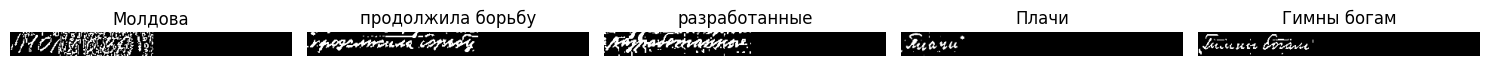


Информация о первом батче:
Размерность батча изображений: torch.Size([16, 1, 32, 374])
Количество текстов в батче: 16
Пример текста: момент
Максимальная ширина в батче: 374

Первые 5 изображений из батча:


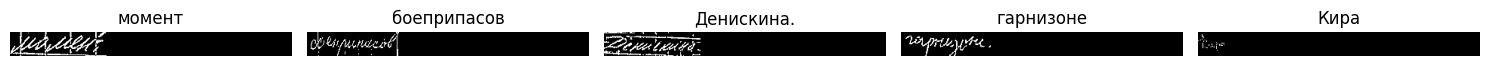

In [12]:
# Загрузка данных
torch_datasets = load_datasets()

# Создание DataLoader
train_loader = DataLoader(
    torch_datasets['train'],
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

# 1. Вывод первых 5 отдельных изображений до батчинга
print("Первые 5 изображений в датасете:")
plt.figure(figsize=(15, 5))
for i in range(5):
    sample = torch_datasets['train'][i]
    img = sample['image'].squeeze().numpy()  # Убираем размерность канала для отображения
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Img {i}\n{sample['text'][:30]}..." if len(sample['text']) > 30 else sample['text'])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Получение и вывод информации о первом батче
print("\nИнформация о первом батче:")
batch = next(iter(train_loader))
images, texts = batch['image'], batch['text']

print(f"Размерность батча изображений: {images.shape}")  # [batch_size, 1, height, max_width]
print(f"Количество текстов в батче: {len(texts)}")
print(f"Пример текста: {texts[0]}")
print(f"Максимальная ширина в батче: {images.shape[3]}")

# 3. Визуализация изображений из батча
print("\nПервые 5 изображений из батча:")
plt.figure(figsize=(15, 5))
for i in range(5):
    img = images[i].squeeze().numpy()  # [1, H, W] -> [H, W]
    
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Batch {i}\n{texts[i][:30]}..." if len(texts[i]) > 30 else texts[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Модель и обучение

### Инициализация и настройки

In [36]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Установка SEED для повторяемости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Алфавит

In [51]:
# Основной алфавит
RUSSIAN_LETTERS = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
DIGITS = '0123456789'
SPECIAL_CHARS = ' !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»№'
LATIN_LETTERS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # Добавляем все латинские

# Полный алфавит
alphabet = (
    RUSSIAN_LETTERS + 
    DIGITS + 
    SPECIAL_CHARS + 
    LATIN_LETTERS  # Добавляем латинские буквы
)

# Удаляем дубликаты (если есть)
alphabet = ''.join(sorted(set(alphabet), key=alphabet.index))
num_classes = len(alphabet) + 1  # +1 для blank символа

print(f"Итоговый алфавит ({len(alphabet)} символов):\n{alphabet}")

Итоговый алфавит (105 символов):
АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789 !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»№ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [ ]:
def collate_fn(batch):
    images = []
    texts = []
    
    for item in batch:
        images.append(item['image'])
        texts.append(item['text'])
    
    max_width = max(img.shape[2] for img in images)
    padded_images = []
    
    for img in images:
        pad = max_width - img.shape[2]
        if pad > 0:
            img = torch.nn.functional.pad(img, (0, pad))
        padded_images.append(img)
    
    # Конвертация текста в индексы с проверкой
    max_text_len = max(len(text) for text in texts)
    targets = torch.zeros(len(texts), max_text_len, dtype=torch.long)
    targets.fill_(num_classes - 1)  # blank символ
    
    for i, text in enumerate(texts):
        text = text.upper()
        for j, char in enumerate(text):
            if char in alphabet:
                targets[i, j] = alphabet.index(char)
            else:
                # Заменяем неизвестные символы на специальный токен
                targets[i, j] = alphabet.index('?') if '?' in alphabet else num_classes - 1
    
    return {
        'image': torch.stack(padded_images),
        'text': texts,
        'targets': targets.to(device)
    }

def load_datasets(save_dir="preprocessed_data"):
    """Загружает датасеты из сохраненного формата"""
    from datasets import DatasetDict, load_from_disk
    
    datasets = {}
    
    for split in ['train', 'test']:
        split_dir = os.path.join(save_dir, split)
        if os.path.exists(split_dir):
            datasets[split] = load_from_disk(split_dir)
    
    # Конвертируем в PyTorch Dataset
    torch_datasets = {
        split: ImageTextDataset(datasets[split])
        for split in datasets.keys()
    }
    
    print(f"Загружено {len(torch_datasets.get('train', []))} train и {len(torch_datasets.get('test', []))} test примеров")
    return torch_datasets

### Архитектура CRNN

In [ ]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_channels, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1), (2, 1)),
            
            nn.Conv2d(512, 512, 2),
            nn.ReLU()
        )
        
        self.lstm = nn.LSTM(512, 256, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # CNN
        x = self.cnn(x)
        
        # Подготовка для RNN
        x = x.squeeze(2)  # [B, C, W]
        x = x.permute(2, 0, 1)  # [W, B, C]
        
        # RNN
        x, _ = self.lstm(x)
        
        # Классификатор
        x = self.fc(x)
        return x

### Вспомогательные функции

In [ ]:
def decode_predictions(preds, alphabet):
    """Декодируем предсказания модели в текст"""
    preds = preds.permute(1, 0, 2)  # (seq_len, batch, num_classes) -> (batch, seq_len, num_classes)
    preds = torch.softmax(preds, dim=2)
    preds = torch.argmax(preds, dim=2)
    preds = preds.detach().cpu().numpy()
    
    texts = []
    for pred in preds:
        text = []
        prev_char = None
        for char_idx in pred:
            if char_idx != len(alphabet) and (prev_char != char_idx or char_idx == len(alphabet)):
                if char_idx < len(alphabet):
                    text.append(alphabet[char_idx])
            prev_char = char_idx
        texts.append(''.join(text))
    
    return texts

def calculate_accuracy(preds, target_texts, alphabet):
    """Мягкая accuracy с визуализацией ошибок"""
    decoded_preds = decode_predictions(preds, alphabet)
    correct = 0
    
    # Вывод первых 5 примеров для отладки
    print("\nПримеры предсказаний:")
    for i in range(min(5, len(decoded_preds))):
        print(f"True: '{target_texts[i]}' | Pred: '{decoded_preds[i]}'")
    
    # Считаем частичные совпадения
    for pred, target in zip(decoded_preds, target_texts):
        target = target.upper()
        if len(pred) > 0 and any(c in target for c in pred):
            correct += 1
    
    return correct / len(decoded_preds)

### Функции обучения и валидации

In [ ]:
def train(model, dataloader, criterion, optimizer, alphabet, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    for batch in tqdm(dataloader, desc="Training"):
        images = batch['image'].to(device)
        texts = batch['text']
        
        # Подготовка targets для CTC
        max_text_len = max(len(text) for text in texts)
        targets = torch.zeros(len(texts), max_text_len, dtype=torch.long)
        targets.fill_(num_classes - 1)  # Заполняем blank символом
        
        for i, text in enumerate(texts):
            text = text.upper()  # Приводим к верхнему регистру
            for j, char in enumerate(text):
                if char in alphabet:
                    targets[i, j] = alphabet.index(char)
        
        targets = targets.to(device)
        target_lengths = torch.tensor([len(text) for text in texts], dtype=torch.long).to(device)
        
        # Forward pass
        preds = model(images)
        # input_lengths = torch.tensor([preds.size(0)] * preds.size(1), dtype=torch.long).to(device)
        input_lengths = torch.full(
            size=(preds.size(1),),  # batch size
            fill_value=preds.size(0),  # seq_len
            dtype=torch.long
        ).to(device)
        
        # Вычисление потерь
        preds = preds.log_softmax(2)
        loss = criterion(preds, targets, input_lengths, target_lengths)
        
        # Backward pass и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Вычисление точности
        acc = calculate_accuracy(preds, texts, alphabet)
        
        running_loss += loss.item()
        running_acc += acc
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_acc / len(dataloader)
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, alphabet, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            images = batch['image'].to(device)
            texts = batch['text']
            
            # Подготовка targets для CTC
            max_text_len = max(len(text) for text in texts)
            targets = torch.zeros(len(texts), max_text_len, dtype=torch.long)
            targets.fill_(num_classes - 1)  # Заполняем blank символом
            
            for i, text in enumerate(texts):
                text = text.upper()  # Приводим к верхнему регистру
                for j, char in enumerate(text):
                    if char in alphabet:
                        targets[i, j] = alphabet.index(char)
            
            targets = targets.to(device)
            target_lengths = torch.tensor([len(text) for text in texts], dtype=torch.long).to(device)
            
            # Forward pass
            preds = model(images)
            # input_lengths = torch.tensor([preds.size(0)] * preds.size(1), dtype=torch.long).to(device)
            input_lengths = torch.full(
                size=(preds.size(1),),  # batch size
                fill_value=preds.size(0),  # seq_len
                dtype=torch.long
            ).to(device)
            
            # Вычисление потерь
            preds = preds.log_softmax(2)
            loss = criterion(preds, targets, input_lengths, target_lengths)
            
            # Вычисление точности
            acc = calculate_accuracy(preds, texts, alphabet)
            
            running_loss += loss.item()
            running_acc += acc
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_acc / len(dataloader)
    
    return epoch_loss, epoch_acc

### Загрузка данных

In [56]:
# Загрузка данных
torch_datasets = load_datasets()

# Создание DataLoader
train_loader = DataLoader(
    torch_datasets['train'],
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

test_loader = DataLoader(
    torch_datasets['test'],
    batch_size=64,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

Загружено 72284 train и 1544 test примеров


### Основной цикл обучения

In [ ]:
def main():
    # Инициализация
    model = CRNN(img_height=32, num_channels=1, num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    criterion = nn.CTCLoss(blank=num_classes-1, zero_infinity=True).to(device)

    # Дебаг перед обучением
    debug_batch = next(iter(train_loader))
    print("Первый батч - текст:", debug_batch['text'][:3])
    with torch.no_grad():
        debug_out = model(debug_batch['image'][:1].to(device))
        print("Пример выхода модели:", debug_out.shape)
        print("Декодированное предсказание:", decode_predictions(debug_out, alphabet)[0])

    # Обучение
    for epoch in range(5):  # Начните с 5 эпох
        model.train()
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images = batch['image'].to(device)
            texts = batch['text']
            
            # Подготовка таргетов
            targets = torch.zeros(len(texts), max(len(t) for t in texts), dtype=torch.long)
            for i, text in enumerate(texts):
                for j, c in enumerate(text.upper()):
                    targets[i,j] = alphabet.index(c) if c in alphabet else num_classes-1
            
            # Forward
            optimizer.zero_grad()
            preds = model(images)
            input_lengths = torch.tensor([preds.size(0)]*preds.size(1), dtype=torch.long)
            target_lengths = torch.tensor([len(t) for t in texts], dtype=torch.long)
            
            loss = criterion(preds.log_softmax(2), targets.to(device), input_lengths, target_lengths)
            
            # Backward
            loss.backward()
            optimizer.step()
        
        # Валидация
        model.eval()
        with torch.no_grad():
            val_loss, val_acc = validate(model, test_loader, criterion, alphabet, device)
        
        print(f"Epoch {epoch+1}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Сохранение модели
        if val_acc > 0.001:  # Сохраняем только если есть прогресс
            torch.save(model.state_dict(), f"crnn_epoch{epoch+1}.pth")

### Обучение


Epoch 1/2


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.73it/s]
d:\Devtools\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 3.8293 | Train Acc: 0.0001
Val Loss: 3.7246 | Val Acc: 0.0000

Epoch 2/2


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.64it/s]


Train Loss: 3.5179 | Train Acc: 0.0000
Val Loss: 3.6274 | Val Acc: 0.0000


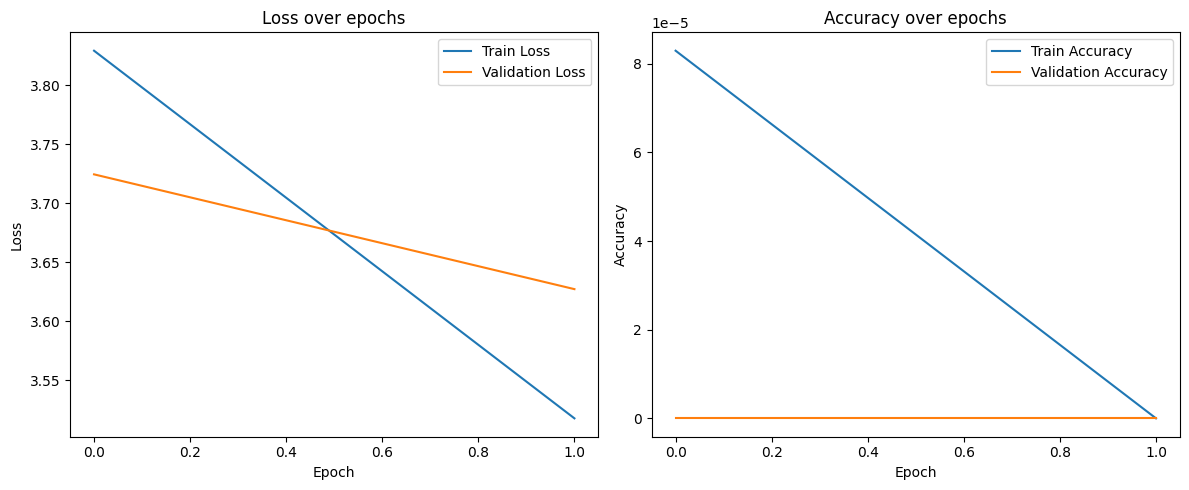


Testing the best model...


Validation: 100%|██████████| 25/25 [00:06<00:00,  3.60it/s]

Test Loss: 3.6274 | Test Accuracy: 0.0000


In [58]:
main()

### Конец

Размер батча изображений: torch.Size([64, 1, 32, 374])
Пример текста: плоскости
Максимальное значение пикселя: 1.0
Минимальное значение пикселя: 0.0


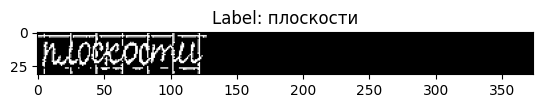

In [49]:
# Проверка данных
sample = next(iter(train_loader))
print("Размер батча изображений:", sample['image'].shape)
print("Пример текста:", sample['text'][0])
print("Максимальное значение пикселя:", sample['image'].max().item())
print("Минимальное значение пикселя:", sample['image'].min().item())

# Визуализация
plt.imshow(sample['image'][0].squeeze().cpu().numpy(), cmap='gray')
plt.title(f"Label: {sample['text'][0]}")
plt.show()

In [50]:
# Проверка соответствия символов
all_chars = set()
for batch in train_loader:
    for text in batch['text']:
        all_chars.update(text.upper())
        
missing_chars = [c for c in all_chars if c not in alphabet]
if missing_chars:
    print(f"ОШИБКА: В алфавите отсутствуют символы: {missing_chars}")
    alphabet += ''.join(missing_chars)
    num_classes = len(alphabet) + 1
    print(f"Обновленный алфавит ({len(alphabet)} символов): {alphabet}")

ОШИБКА: В алфавите отсутствуют символы: ['O', 'H', 'P', 'Y', 'B', 'S', 'T', 'I', 'U', 'X', '»', '№', 'E', 'C', 'R', '«']
Обновленный алфавит (92 символов): АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789 !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~OHPYBSTIUX»№ECR«


In [ ]:
# # Экстренная проверка данных
# debug_batch = next(iter(train_loader))
# print("\n=== DEBUG START ===")
# print("Размеры изображений:", debug_batch['image'].shape)
# print("Пример 5 текстов:", debug_batch['text'][:5])
# print("Мин/Макс пикселей:", debug_batch['image'].min().item(), debug_batch['image'].max().item())

# # Проверка преобразования текста в индексы
# sample_text = debug_batch['text'][0]
# print(f"\nТекст: '{sample_text}'")
# print("Индексы:", [alphabet.index(c) if c in alphabet else 'UNK' for c in sample_text.upper()])

# # Проверка forward pass
# model.eval()
# with torch.no_grad():
#     sample_output = model(debug_batch['image'][:1].to(device))
#     print("\nВыход модели shape:", sample_output.shape)
#     print("Пример предсказания:", decode_predictions(sample_output, alphabet)[0])
# print("=== DEBUG END ===\n")


=== DEBUG START ===
Размеры изображений: torch.Size([64, 1, 32, 374])
Пример 5 текстов: ['химическое', 'пища.', 'Найдены', 'равен', 'Начало']
Мин/Макс пикселей: 0.0 1.0

Текст: 'химическое'
Индексы: [22, 9, 13, 9, 24, 5, 18, 11, 15, 5]


TypeError: linear(): argument 'input' (position 1) must be Tensor, not tuple